In [3]:
pip install seaborn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.9/294.9 kB 9.3 MB/s eta 0:00:00

[notice] A new release of pip is available: 23.3.1 -> 24.3.1
[notice] To update, run: python3 -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [4]:

import matplotlib.pyplot as plt
import seaborn as sns
from keras.models import Sequential
from keras.layers import Dense, Conv2D, MaxPool2D, Flatten, Dropout, BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import LabelBinarizer
import pandas as pd
import numpy as np

In [5]:
# Load the datasets
train_df = pd.read_csv('sign_mnist_train.csv')
test_df = pd.read_csv('sign_mnist_test.csv')

# Separate labels and features
y_train = train_df['label']
y_test = test_df['label']
x_train = train_df.drop(columns=['label']).values
x_test = test_df.drop(columns=['label']).values

# Label Binarization for one-hot encoding
label_binarizer = LabelBinarizer()
y_train = label_binarizer.fit_transform(y_train)
y_test = label_binarizer.transform(y_test)

# Normalize features
x_train = x_train / 255.0
x_test = x_test / 255.0

# Reshape for CNN input
x_train = x_train.reshape(-1, 28, 28, 1)
x_test = x_test.reshape(-1, 28, 28, 1)

In [6]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import LearningRateScheduler

# Define the CNN model
model = Sequential([
    Conv2D(75, (3, 3), activation='relu', input_shape=(28, 28, 1), kernel_initializer='he_normal'),
    BatchNormalization(),
    MaxPool2D((2, 2)),
    Conv2D(50, (3, 3), activation='relu', kernel_initializer='he_normal'),
    Dropout(0.2),
    BatchNormalization(),
    MaxPool2D((2, 2)),
    Conv2D(25, (3, 3), activation='relu', kernel_initializer='he_normal'),
    BatchNormalization(),
    MaxPool2D((2, 2)),
    Flatten(),
    Dense(512, activation='relu', kernel_initializer='he_normal'),
    Dropout(0.3),
    Dense(24, activation='softmax')  # 24 classes
])

# Compile the model
optimizer = Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

# Define learning rate scheduler
def scheduler(epoch, lr):
    if epoch > 10:
        return lr * 0.5
    return lr

lr_scheduler = LearningRateScheduler(scheduler)

In [7]:
# Data augmentation
datagen = ImageDataGenerator(
    rotation_range=10,
    zoom_range=0.1,
    width_shift_range=0.1,
    height_shift_range=0.1
)
datagen.fit(x_train)

In [8]:
# Train the model
history = model.fit(
    datagen.flow(x_train, y_train, batch_size=128),
    epochs=20,
    validation_data=(x_test, y_test),
    callbacks=[lr_scheduler]
)

Epoch 1/20
215/215 [==============================] - 13s 57ms/step - loss: 1.6619 - accuracy: 0.4933 - val_loss: 2.1811 - val_accuracy: 0.3296 - lr: 0.0010
Epoch 2/20
215/215 [==============================] - 12s 54ms/step - loss: 0.5860 - accuracy: 0.7975 - val_loss: 0.5819 - val_accuracy: 0.7970 - lr: 0.0010
Epoch 3/20
215/215 [==============================] - 12s 55ms/step - loss: 0.3528 - accuracy: 0.8794 - val_loss: 0.1504 - val_accuracy: 0.9519 - lr: 0.0010
Epoch 4/20
215/215 [==============================] - 11s 52ms/step - loss: 0.2512 - accuracy: 0.9146 - val_loss: 0.1313 - val_accuracy: 0.9576 - lr: 0.0010
Epoch 5/20
215/215 [==============================] - 12s 58ms/step - loss: 0.1855 - accuracy: 0.9371 - val_loss: 0.1165 - val_accuracy: 0.9601 - lr: 0.0010
Epoch 6/20
215/215 [==============================] - 12s 56ms/step - loss: 0.1470 - accuracy: 0.9502 - val_loss: 0.1334 - val_accuracy: 0.9593 - lr: 0.0010
Epoch 7/20
215/215 [==============================] - 11s 

In [12]:
model.save('sign_mnist_model.h5')

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [13]:
# Predictions
predictions = model.predict(x_test)
y_pred = np.argmax(predictions, axis=1)
y_true = np.argmax(y_test, axis=1)

# Classification Report
print(classification_report(y_true, y_pred))

225/225 [==============================] - 1s 5ms/step
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       331
           1       1.00      1.00      1.00       432
           2       1.00      1.00      1.00       310
           3       1.00      1.00      1.00       245
           4       1.00      1.00      1.00       498
           5       1.00      1.00      1.00       247
           6       1.00      0.98      0.99       348
           7       0.98      1.00      0.99       436
           8       1.00      1.00      1.00       288
           9       1.00      1.00      1.00       331
          10       1.00      1.00      1.00       209
          11       1.00      1.00      1.00       394
          12       1.00      1.00      1.00       291
          13       1.00      1.00      1.00       246
          14       1.00      1.00      1.00       347
          15       1.00      1.00      1.00       164
          16       1.00   

1/1 [==============================] - 0s 10ms/step


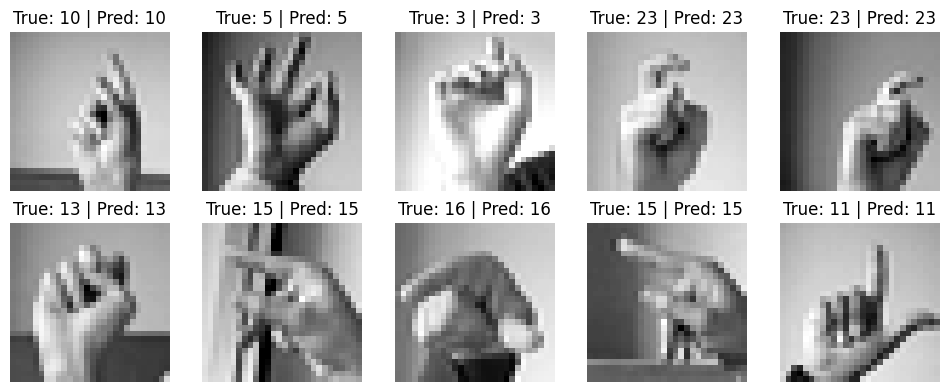

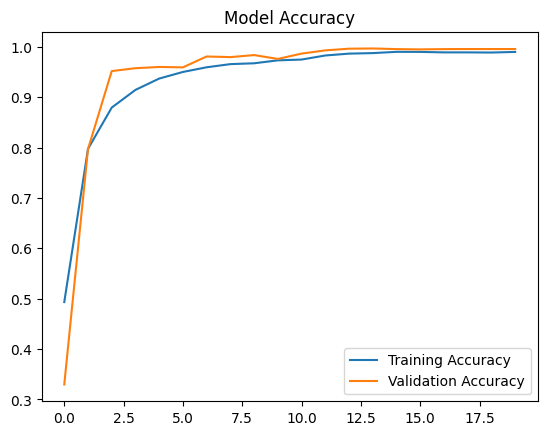

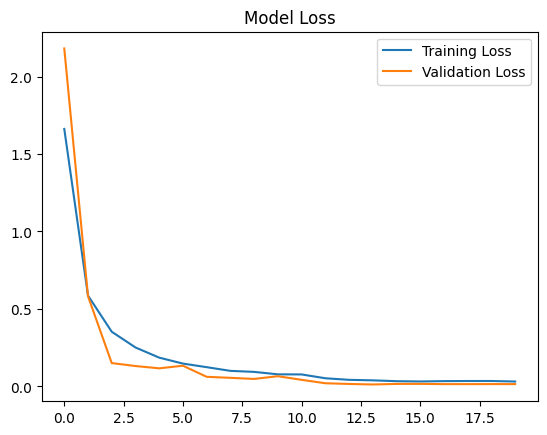

In [14]:
# Plot sample predictions
def plot_predictions(x_test, y_true, model, label_binarizer, num_samples=10):
    plt.figure(figsize=(12, 12))
    for i in range(num_samples):
        ax = plt.subplot(5, 5, i + 1)
        random_index = np.random.randint(0, len(x_test))
        plt.imshow(x_test[random_index].reshape(28, 28), cmap='gray')
        prediction = model.predict(x_test[random_index].reshape(1, 28, 28, 1))
        predicted_label = np.argmax(prediction)
        true_label = np.argmax(y_test[random_index])
        plt.title(f"True: {label_binarizer.classes_[true_label]} | Pred: {label_binarizer.classes_[predicted_label]}")
        plt.axis("off")
    plt.show()

plot_predictions(x_test, y_test, model, label_binarizer)

# Training performance
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.title("Model Accuracy")
plt.show()

plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title("Model Loss")
plt.show()